In [2]:
!pip install tensorflow pandas numpy seaborn matplotlib scikit-learn

In [3]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import accuracy_score

In [4]:
# Load the data_nn
url = 'https://drive.google.com/file/d/1qWyQao5dLZiyh6OO4ck-emm5zKAS40re/view?usp=drive_link'
url = 'https://drive.google.com/uc?id=' + url.split('/')[-2]  # Process for pandas
data_nn = pd.read_csv(url, sep=';')  # CSV is semicolon-separated

# data_nn preprocessing
print("\nChecking for missing values:")
print(data_nn.isnull().sum())

# Drop duplicates if any
data_nn = data_nn.drop_duplicates()
print("\nNumber of rows after removing duplicates:", data_nn.shape[0])

# Feature selection and preprocessing
features = data_nn.drop(columns=['G3'])
labels = data_nn['G3']
data_nn_numeric = data_nn

# Convert categorical features to numerical with binary dummy variables
categorical_cols = features.select_dtypes(exclude=['number']).columns
features = pd.get_dummies(features, columns=categorical_cols, drop_first=True).astype(int)
data_nn_numeric = pd.get_dummies(data_nn_numeric, columns=categorical_cols, drop_first=True).astype(int)
labels = np.where(labels >= 10, 1, 0)

# Calculate feature correlation
numeric_columns = data_nn_numeric.select_dtypes(include=[np.number])
correlation = numeric_columns.corr()
print("\nCorrelation with target variable G3:")
print(correlation['G3'].sort_values(ascending=False))

# Remove low correlation features
low_corr_features = correlation['G3'][abs(correlation['G3']) < 0.1].index
low_corr_features = low_corr_features.difference(['studytime','internet_yes'])
features = features.drop(columns=low_corr_features, errors='ignore')
print("\nFeatures dropped due to low correlation:", list(low_corr_features))



Checking for missing values:
school        0
sex           0
age           0
address       0
famsize       0
Pstatus       0
Medu          0
Fedu          0
Mjob          0
Fjob          0
reason        0
guardian      0
traveltime    0
studytime     0
failures      0
schoolsup     0
famsup        0
paid          0
activities    0
nursery       0
higher        0
internet      0
romantic      0
famrel        0
freetime      0
goout         0
Dalc          0
Walc          0
health        0
absences      0
G1            0
G2            0
G3            0
dtype: int64

Number of rows after removing duplicates: 395

Correlation with target variable G3:
G3                   1.000000
G2                   0.904868
G1                   0.801468
Medu                 0.217147
higher_yes           0.182465
Fedu                 0.152457
Mjob_health          0.116158
address_U            0.105756
sex_M                0.103456
paid_yes             0.101996
internet_yes         0.098483
studytime     

In [5]:
# Split and scale data_nn
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Custom callback to track errors per epoch
class ErrorTracker(Callback):
    def __init__(self, validation_data_nn):
        super(ErrorTracker, self).__init__()
        self.val_data_nn = validation_data_nn
        self.train_errors = []
        self.test_errors = []

    def on_epoch_end(self, epoch, logs={}):
        train_pred = (self.model.predict(self.model.X) > 0.5).astype(int)
        test_pred = (self.model.predict(self.val_data_nn[0]) > 0.5).astype(int)

        train_error = 1 - np.mean(train_pred.flatten() == self.model.y)
        test_error = 1 - np.mean(test_pred.flatten() == self.val_data_nn[1])

        self.train_errors.append(train_error * 100)
        self.test_errors.append(test_error * 100)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


In [6]:

# Create and train the model
model = Sequential([
    Dense(64, activation='relu', input_dim=X_train.shape[1]),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
error_tracker = ErrorTracker((X_test, y_test))
model.X = X_train
model.y = y_train
print("\nModel: ", model.summary())
history = model.fit(X_train, y_train,
                   epochs=5,
                   batch_size=32,
                   validation_data=(X_test, y_test),
                   callbacks=[error_tracker],
                   verbose=1)
# Save initial weights
initial_weights = model.get_weights()

# Print initial weights
print("\nInitial Weights:")
for i, layer_weights in enumerate(initial_weights):
    print(f"Layer {i + 1} Weights:\n{layer_weights}\n")


# Evaluate the model
y_pred = (model.predict(X_test) > 0.5).astype(int)
y_prob = model.predict(X_test)

# Print confusion matrix and classification report
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", classification_report(y_test, y_pred))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │           1,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │           1,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,145 (8.38 KB)

 Trainable params: 2,145 (8.38 KB)

 Non-trainable params: 0 (0.00 B)


Model:  None
Epoch 1/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.4068 - loss: 0.8148 - val_accuracy: 0.5443 - val_loss: 0.6920
Epoch 2/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.4880 - loss: 0.7117 - val_accuracy: 0.7089 - val_loss: 0.6330
Epoch 3/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6145 - loss: 0.6334 - val_accuracy: 0.7595 - val_loss: 0.5818
Epoch 4/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7101 - loss: 0.5601 - val_accuracy: 0.8101 - val_loss: 0.5357
Epoch 5/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.7292 - loss: 0.5415 - val_acc

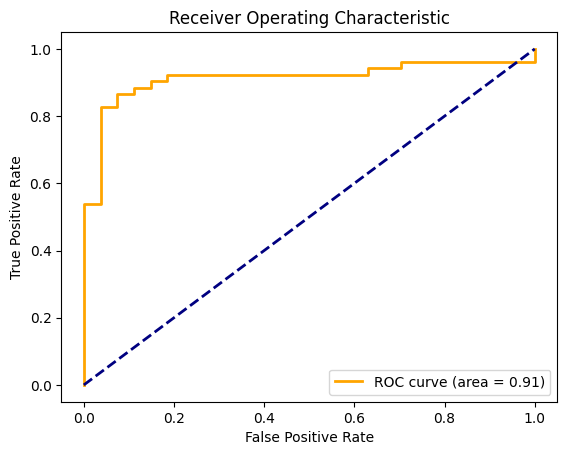

In [7]:
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='orange', lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()


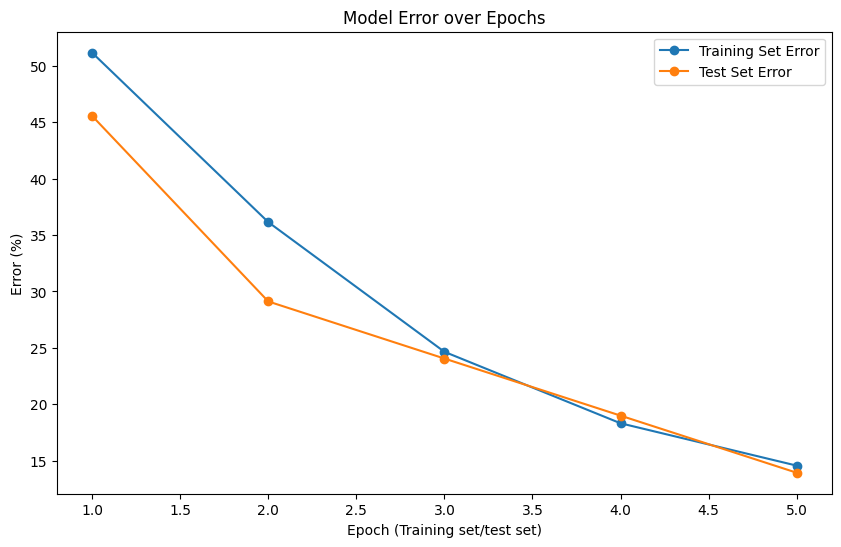

In [8]:

# Plot error rates over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(error_tracker.train_errors) + 1),
         error_tracker.train_errors,
         label="Training Set Error",
         marker='o')
plt.plot(range(1, len(error_tracker.test_errors) + 1),
         error_tracker.test_errors,
         label="Test Set Error",
         marker='o')
plt.xlabel("Epoch (Training set/test set)")
plt.ylabel("Error (%)")
plt.title("Model Error over Epochs")
plt.legend()
plt.show()


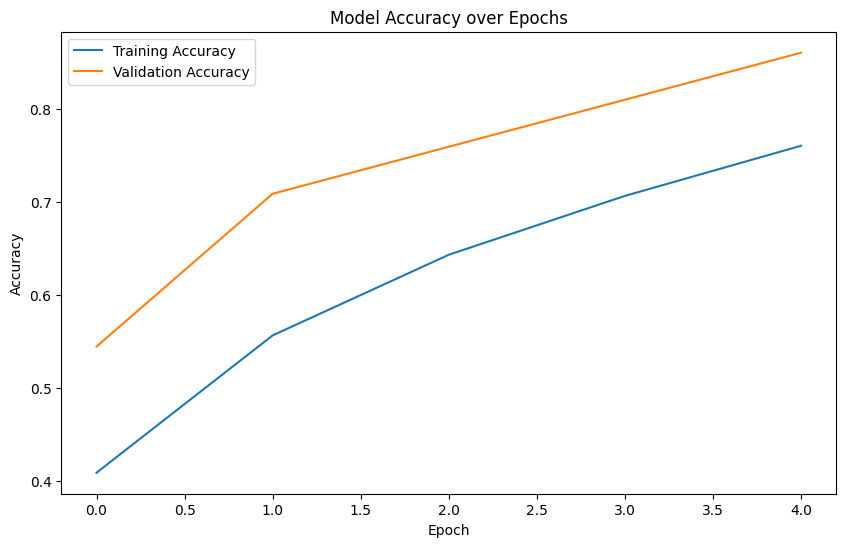

In [9]:

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
